In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [4]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()


c:\Users\olofs\anaconda3\envs\machine_learning\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [42]:
X = mnist.data
y = mnist.target.astype(np.uint8)

In [43]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


# Split into training sets and test sets

In [44]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [108]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(60000, 784)
(10000, 784)
(60000,)
(10000,)


# Lets plot the 13th image in the dataset


In [46]:
y_train[12]

3

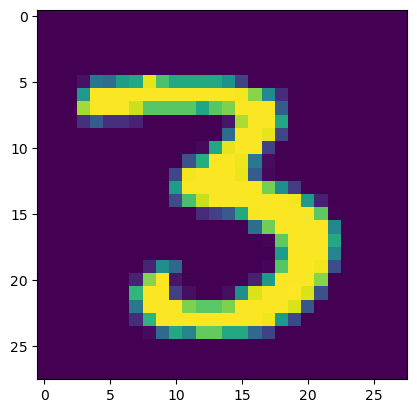

In [47]:
first_trans = X_train[12].reshape(28, 28)
plt.imshow(first_trans)

# Use PCA to remove useless data

In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Make sure it worked

In [49]:
print(X_train_reduced.shape)
print(X_test_reduced.shape)

(60000, 154)
(10000, 154)


# There are no only 154 dimensions, meaning we can no longer viasually graph the data to see the figure
# Let's take the nearest grid we can (12x12) to see this.

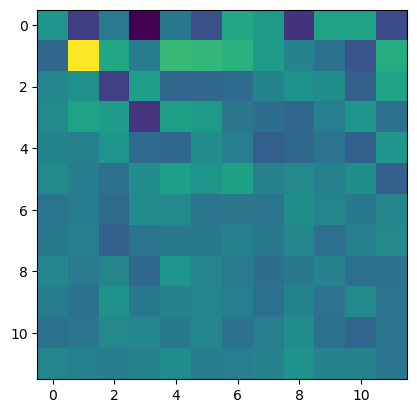

In [50]:
first_trans = X_train_reduced[0,:144].reshape(12, 12)
plt.imshow(first_trans)

# Try a few different classifíers

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

kn_clf = KNeighborsClassifier()
log_reg_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
svc_clf = SVC()

clf_list = []
pred_list = []
scores_list = []


for clf in (kn_clf, log_reg_clf, rf_clf, svc_clf):
    clf.fit(X_train_reduced, y_train)
    y_pred = clf.predict(X_test_reduced)
    pred_list.append(y_pred)
    score = accuracy_score(y_test, y_pred)
    clf_list.append(clf)
    scores_list.append(score)
    clf_name = type(clf).__name__
    pred_name = ('y_pred_' + clf_name)





c:\Users\olofs\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
for score, name in enumerate(clf_list):
    print(f"{name}: {scores_list[score]}")

KNeighborsClassifier(): 0.9712
LogisticRegression(): 0.9201
RandomForestClassifier(): 0.9477
SVC(): 0.9832


In [53]:
y_pred_kn_clf, y_pred_log_reg_clf, y_pred_rf_clf, y_pred_svc_clf = pred_list[0:4]



In [54]:
print(y_pred_log_reg_clf)

[7 2 1 ... 4 5 6]


In [55]:
print(accuracy_score(y_test, y_pred_kn_clf))

0.9712


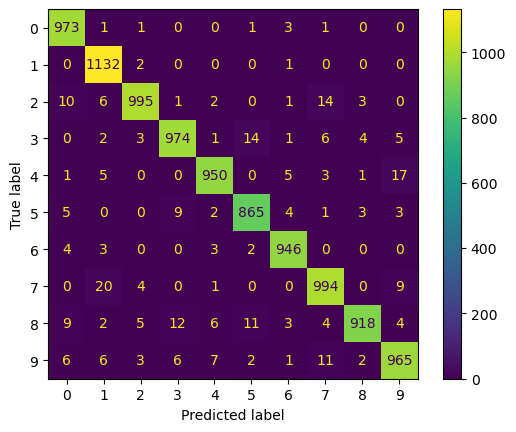

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_kn_clf)).plot()

In [57]:

# arr1 = np.array([1, 1, 3, 4, 5])
# arr2 = np.array([3, 3, 7, 9, 11])

# idx = np.where((arr1 == 1) & (arr2 == 3))[0]



In [106]:
def display_missed_predictions(y_pred, actual_y_value, predicted_y_value):
    misclassified = np.where(((y_test == actual_y_value) & (y_test != y_pred) & (y_pred == predicted_y_value)))
    list_of_misses = []
    for i in misclassified:
        for x in i:
            list_of_misses.append(x)
    if len(list_of_misses) == 0:
        return print("No missclassifications in this combination.")
        pass
    elif len(list_of_misses) == 1:
        missed = list_of_misses[0]
        pic = X_test[missed].reshape(28, 28)
        plt.imshow(pic)
        return 
    elif len(list_of_misses) % 2 == 0 and len(list_of_misses) != 1:
        tl = int(len(list_of_misses) / 2)
    else:
        tl = int((len(list_of_misses) + 1) / 2)
    numplots = 1
    for i in list_of_misses:
        pic = X_test[i].reshape(28, 28)
        plt.subplot(tl, tl, numplots)
        plt.imshow(pic)
        numplots += 1



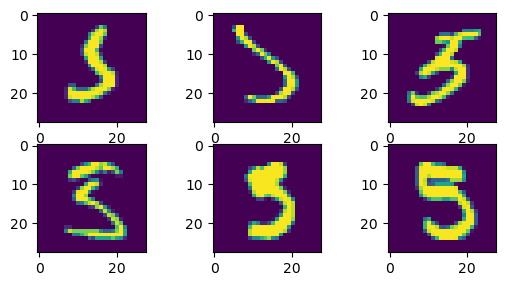

In [107]:
display_missed_predictions(y_pred_svc_clf, 5, 3)

# KNN produced a 97% accuracy. Let's tweak the hyperparameters a little bit.

# Quick look at how no of neighbors affect the result
# First run: 1, 5, 10, 20, 50, 100
# 5 yielded the best result
# Second run: 3, 4, 5, 6, 7
# 3 yielded the best result

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


for i in (3, 4, 5, 6, 7):
    kn_clf = KNeighborsClassifier(n_neighbors=i)
    kn_clf.fit(X_train_reduced, y_train)
    y_pred = kn_clf.predict(X_test_reduced)
    score = accuracy_score(y_test, y_pred)
    print(f"{i} Neighbors: {score}")


3 Neighbors: 0.9722
4 Neighbors: 0.9706
5 Neighbors: 0.9712
6 Neighbors: 0.97
7 Neighbors: 0.971


In [62]:
from sklearn.model_selection import GridSearchCV

clf = KNeighborsClassifier()

param_grid = {'weights': [('uniform'), ('distance')], 'n_neighbors': (3, 4, 5, 6)}

grid = GridSearchCV(clf, param_grid, cv=6)
grid.fit(X_train, y_train)

grid.best_params_


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.217254,0.007876,7.401912,0.020679,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.9709,0.9709,0.9714,0.9698,0.9655,0.9721,0.970100,0.002169,5
1,0.215435,0.007223,7.242019,0.062993,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.9716,0.9727,0.9718,0.9707,0.9671,0.9730,0.971150,0.001960,3
2,0.209188,0.001693,7.587993,0.160261,4,uniform,"{'n_neighbors': 4, 'weights': 'uniform'}",0.9683,0.9689,0.9709,0.9678,0.9649,0.9725,0.968883,0.002399,7
3,0.224634,0.010341,8.059009,0.308880,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",0.9722,0.9728,0.9733,0.9704,0.9689,0.9740,0.971933,0.001757,1
4,0.217654,0.007885,8.491716,0.705840,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.9696,0.9702,0.9713,0.9698,0.9650,0.9720,0.969650,0.002243,6
5,0.290218,0.044076,8.754954,1.113646,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.9701,0.9722,0.9720,0.9698,0.9674,0.9733,0.970800,0.001945,4
6,0.227294,0.012138,8.060432,0.404529,6,uniform,"{'n_neighbors': 6, 'weights': 'uniform'}",0.9672,0.9696,0.9699,0.9682,0.9649,0.9711,0.968483,0.002028,8
7,0.231725,0.020887,8.103330,0.332258,6,distance,"{'n_neighbors': 6, 'weights': 'distance'}",0.9714,0.9723,0.9721,0.9709,0.9674,0.9739,0.971333,0.001991,2


In [ ]:
# X_train_rf, X_test_rf, y_train_rf, y_test_rf = X[:6000], X[6000:7000], y[:6000], y[6000:7000]
# pca = PCA(n_components=154)
# X_train_reduced = pca.fit_transform(X_train_rf)
# X_test_reduced = pca.transform(X_test_rf)




In [ ]:
X_test_reduced.shape

(1000, 154)

# First run shows max_depth 20 (5, 10, 20) and n_estimators 500 (100, 500, 1000) (8min, 15sec)
# First run yielded 93.95%
# Second run shows max_depth 18 (18, 20, 22) and n_estimators 400 (400, 500, 600) (8min, 32sec)
# Second run yielded 94.02%
# Third run shows max_depth 16 (16, 17, 18) and n_estimators 400 (350, 400, 450) (7min, 8sec)
# Third run yielded 93.90%

# Since no improvemetn was made, we'll stop here

In [ ]:
clf = RandomForestClassifier(oob_score=True)

param_grid = {'max_depth': (16, 17, 18), 'n_estimators': (350, 400, 450)}

grid = GridSearchCV(clf, param_grid, cv=4)
grid.fit(X_train_rf, y_train_rf)

grid.best_params_


{'max_depth': 18, 'n_estimators': 400}

In [ ]:
pd.DataFrame(grid.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,9.207220,0.245285,0.207756,0.014178,16,350,"{'max_depth': 16, 'n_estimators': 350}",0.929333,0.940000,0.942667,0.935333,0.936833,0.005063,9
1,10.347963,0.028648,0.247822,0.016095,16,400,"{'max_depth': 16, 'n_estimators': 400}",0.933333,0.939333,0.940667,0.936000,0.937333,0.002867,7
2,11.665554,0.029657,0.268421,0.004911,16,450,"{'max_depth': 16, 'n_estimators': 450}",0.932000,0.944667,0.938667,0.937333,0.938167,0.004506,4
3,9.045147,0.033827,0.215050,0.010488,17,350,"{'max_depth': 17, 'n_estimators': 350}",0.929333,0.940000,0.942000,0.936667,0.937000,0.004819,8
4,10.319030,0.041187,0.265438,0.021875,17,400,"{'max_depth': 17, 'n_estimators': 400}",0.935333,0.942667,0.940000,0.936667,0.938667,0.002867,2
5,11.678234,0.056384,0.292835,0.004299,17,450,"{'max_depth': 17, 'n_estimators': 450}",0.931333,0.944000,0.939333,0.937333,0.938000,0.004546,6
6,9.063211,0.056687,0.219823,0.013318,18,350,"{'max_depth': 18, 'n_estimators': 350}",0.934000,0.944000,0.941333,0.933333,0.938167,0.004604,3
7,10.439532,0.042795,0.262552,0.021660,18,400,"{'max_depth': 18, 'n_estimators': 400}",0.930000,0.945333,0.944000,0.936000,0.938833,0.006225,1
8,11.684488,0.055926,0.282677,0.007355,18,450,"{'max_depth': 18, 'n_estimators': 450}",0.933333,0.940000,0.940000,0.938667,0.938000,0.002749,5


In [ ]:
grid.best_estimator_

RandomForestClassifier(max_depth=18, n_estimators=400, oob_score=True)

In [ ]:

y_pred = grid.predict(X_test_rf)
score = accuracy_score(y_test_rf, y_pred)
grid.best_score_


print(f"Best Score: {grid.best_score_:.4f} \nAccuracy Score: {score:.4f}")

Best Score: 0.9388 
Accuracy Score: 0.9480


0.948


# Try SVM

In [ ]:

X_train_reduced.shape
y_train.shape

(60000,)

In [ ]:
svc_clf = SVC()

grid_param = {'C': (1, 5, 10), 'kernel': [('poly'), ('rbf')]}
grid_svm = GridSearchCV(svc_clf, grid_param, cv=8)
grid_svm.fit(X_test_reduced, y_test)
result = pd.DataFrame(grid_svm.cv_results_)


In [ ]:
grid_svm.best_params_

{'C': 10, 'kernel': 'poly'}

In [ ]:
pd.DataFrame(grid_svm.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
0,4.578553,0.057360,0.426039,0.013121,1,poly,"{'C': 1, 'kernel': 'poly'}",0.9616,0.9464,0.9704,0.9488,0.9792,0.9864,0.9848,0.9696,0.9684,0.014272,5
1,3.164437,0.460229,0.881185,0.132945,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.9520,0.9448,0.9632,0.9432,0.9776,0.9872,0.9880,0.9720,0.9660,0.016871,6
2,5.145878,0.522935,0.448860,0.039617,5,poly,"{'C': 5, 'kernel': 'poly'}",0.9648,0.9504,0.9696,0.9568,0.9800,0.9880,0.9832,0.9720,0.9706,0.012170,2
3,3.435658,0.387523,0.834375,0.055785,5,rbf,"{'C': 5, 'kernel': 'rbf'}",0.9584,0.9456,0.9640,0.9528,0.9816,0.9920,0.9880,0.9728,0.9694,0.015848,4
4,4.734699,0.260149,0.424675,0.032041,10,poly,"{'C': 10, 'kernel': 'poly'}",0.9640,0.9496,0.9680,0.9600,0.9808,0.9880,0.9832,0.9728,0.9708,0.012113,1
5,3.026964,0.189160,0.813879,0.044615,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.9584,0.9464,0.9648,0.9528,0.9824,0.9920,0.9880,0.9728,0.9697,0.015745,3
